In [5]:
# === Import Library ===
import sys
import os
sys.path.append(os.path.abspath(".."))  # Memastikan folder utils bisa diakses

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from utils.preprocessing import load_and_clean_data
import numpy as np

# === [1] Load & Preprocessing Data ===
df = load_and_clean_data('../data/bbca_stock_2019-2025.csv')

# Normalisasi data harga penutupan (Close)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']].values)

# === [2] Membuat Data Sequence ===
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_close)

# Ubah dimensi X menjadi (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# === [3] Definisi Arsitektur Model LSTM ===
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

# Kompilasi model
model.compile(optimizer='adam', loss='mse')

# === [4] Early Stopping Callback ===
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# === [5] Melatih Model ===
model.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stop])

# === [6] Simpan Model dalam Format HDF5 (.h5) ===
os.makedirs("model", exist_ok=True)  # Buat folder jika belum ada
model.save("../model/lstm_model.h5")


Epoch 1/100
44/44 [==============================] - 5s 44ms/step - loss: 0.0273
Epoch 2/100
44/44 [==============================] - 2s 44ms/step - loss: 0.0012
Epoch 3/100
44/44 [==============================] - 2s 43ms/step - loss: 9.6643e-04
Epoch 4/100
44/44 [==============================] - 2s 44ms/step - loss: 9.3150e-04
Epoch 5/100
44/44 [==============================] - 2s 43ms/step - loss: 9.7015e-04
Epoch 6/100
44/44 [==============================] - 2s 42ms/step - loss: 9.1409e-04
Epoch 7/100
44/44 [==============================] - 2s 43ms/step - loss: 8.3170e-04
Epoch 8/100
44/44 [==============================] - 2s 43ms/step - loss: 8.3429e-04
Epoch 9/100
44/44 [==============================] - 2s 43ms/step - loss: 8.0959e-04
Epoch 10/100
44/44 [==============================] - 2s 43ms/step - loss: 7.9050e-04
Epoch 11/100
44/44 [==============================] - 2s 43ms/step - loss: 7.7182e-04
Epoch 12/100
44/44 [==============================] - 2s 42ms/step - lo

c:\bbca-lstm-project\.conda\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 3s 45ms/step


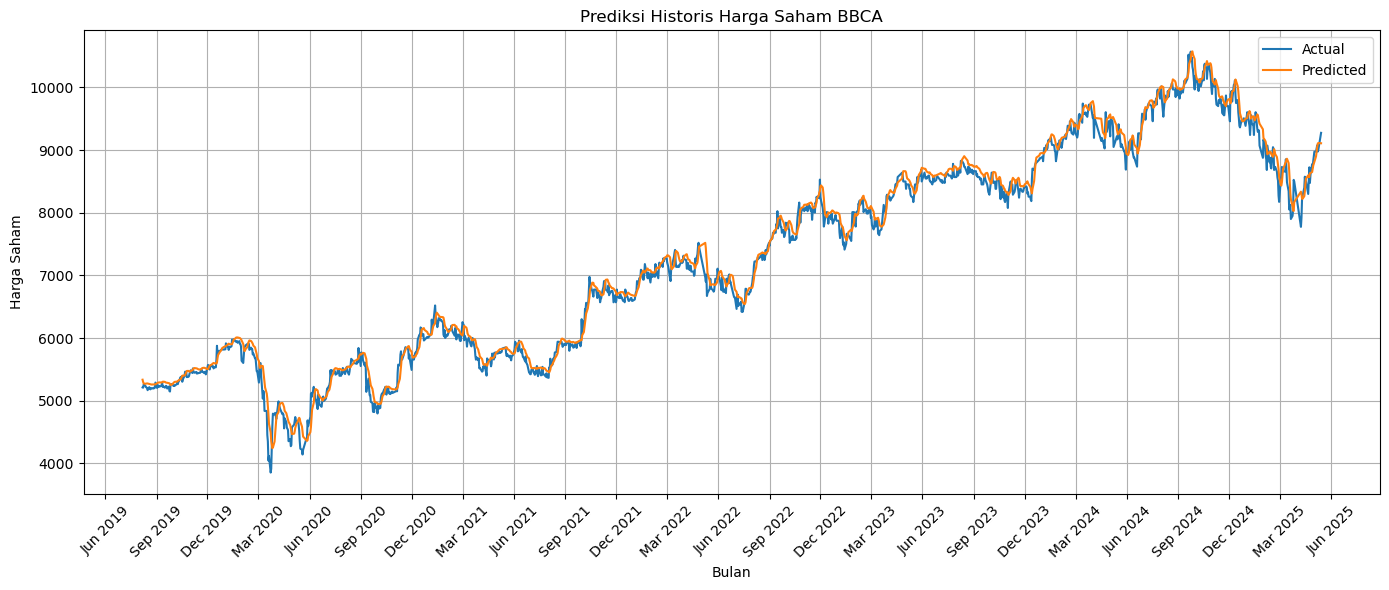

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ambil tanggal mulai dari index ke-60 (karena data sequence dimulai dari situ)
dates = df['Date'].iloc[60:].reset_index(drop=True)

y_pred = model.predict(X)

# Invers transform hasil prediksi dan nilai aktual agar kembali ke skala harga sebenarnya
predicted_actual = scaler.inverse_transform(y_pred)
actual_actual = scaler.inverse_transform(y)

# Buat dataframe prediksi
pred_df = pd.DataFrame({
    'Date': dates,
    'Actual': actual_actual.flatten(),
    'Predicted': predicted_actual.flatten()
})

# Visualisasi dengan format bulanan
plt.figure(figsize=(14, 6))
plt.plot(pred_df['Date'], pred_df['Actual'], label='Actual')
plt.plot(pred_df['Date'], pred_df['Predicted'], label='Predicted')
plt.title('Prediksi Historis Harga Saham BBCA')
plt.xlabel('Bulan')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)

# Format sumbu X sebagai bulan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g. Jan 2022
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # tampilkan tiap 3 bulan
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 33ms/step


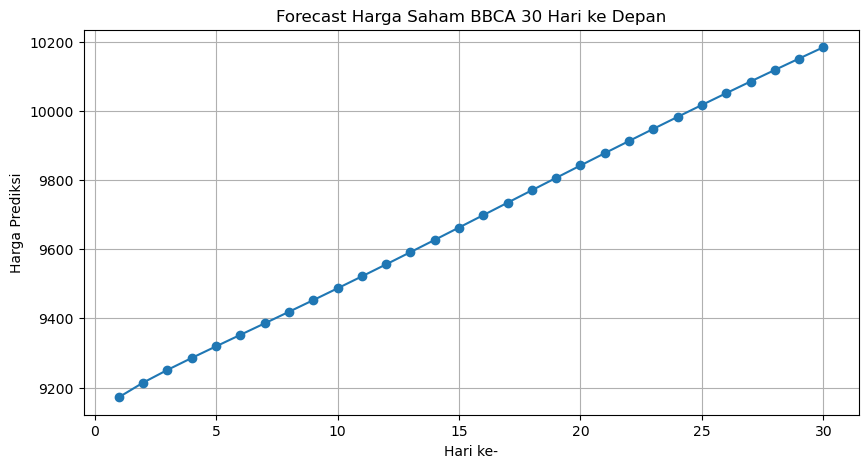

In [7]:
future_input = scaled_close[-60:].reshape(1, 60, 1)
future_preds = []

for _ in range(30):
    next_pred = model.predict(future_input)[0][0]
    future_preds.append(next_pred)
    
    # Geser window
    future_input = np.append(future_input[:, 1:, :], [[[next_pred]]], axis=1)

# Invers transform hasil prediksi ke nilai asli
future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Visualisasi hasil forecast
plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), future_prices, marker='o')
plt.title('Forecast Harga Saham BBCA 30 Hari ke Depan')
plt.xlabel('Hari ke-')
plt.ylabel('Harga Prediksi')
plt.grid(True)
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_actual, predicted_actual))
mae = mean_absolute_error(actual_actual, predicted_actual)
mape = np.mean(np.abs((actual_actual - predicted_actual) / actual_actual)) * 100

print("=== Evaluasi Akurasi Model ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


=== Evaluasi Akurasi Model ===
RMSE: 153.98
MAE : 116.44
MAPE: 1.70%
